# Double Pendulum


Let's setup some parameters

In [4]:
import numpy as np

g        = 9.8             # m/s
l1       = 1.2             # m
l2       = .7              # m
theta1_0 = np.pi/5         # other initial angle
theta2_0 = np.pi           # initial angle
m1       = .10             # kg
m2       = .05             # kg
dt       = 1.e-3           # time steps
max_t    = 5.0             # max time 
nsteps   = long(max_t/dt)  # number of steps

How many steps are there?

In [5]:
print "nsteps:", nsteps

nsteps: 5000


In [7]:
# Import numpy for numerical calculations, vectors, etc.
from numpy import array, zeros, cos, sin, pi
from numpy.linalg import norm as norm
from scipy.integrate import ode

## Helper functions for various calculations

### Calculate various derivatives

The time derivative of $\theta_1$

In [8]:
def dtheta1(theta1, theta2, p1, p2):
    num = l2*p1 - l1*p2*cos(theta1 - theta2)
    den = l1*l1*l2*(m1 + m2*sin(theta1 - theta2)**2)
    return num/den

The time derivative of $\theta_2$

In [9]:
def dtheta2(theta1, theta2, p1, p2):
    num = l1*(m1+m2)*p2 - l2*m2*p1*cos(theta1-theta2)
    den = l1*l2*l2*m2*(m1+ m2*sin(theta1-theta2)**2)
    return num/den

The time derivative of $p_1$

In [10]:
def dp1(theta1, theta2, p1, p2, c1, c2):
    return -(m1+m2)*g*l1*sin(theta1) - c1 + c2

The time derivative of $p_2$

In [11]:
def dp2(theta1, theta2, p1, p2, c1, c2):
    return -m2*g*l2*sin(theta2) + c1 - c2

Helper function to calculate a constant $C_1$

In [12]:
def C1(theta1, theta2, p1, p2):
    num = p1*p2*sin(theta1 - theta2)
    den = l1*l2*(m1 + m2*sin(theta1 - theta2)**2)
    return num/den

Helper function to calculate constant $C_2$

In [13]:
def C2(theta1, theta2, p1, p2):
    num = l2*l2*m2*p1*p2 + l1*(m1 + m2)*p2**2 - l1*l2*m2*p1*p2*cos(theta1-theta2)
    den = 2*l1*l1*l2*l2*(m1 + m2*sin(theta1-theta2)**2)**2*sin(2*(theta1-theta2))
    return num/den

Calculate the derivatives for each $\theta_1,\theta_2,p_1,p_2$

In [14]:
def deriv(t, y):
    theta1, theta2, p1, p2 = y[0], y[1], y[2], y[3]

    _c1 = C1(theta1, theta2, p1, p2)
    _c2 = C2(theta1, theta2, p1, p2)

    _dtheta1 = dtheta1(theta1, theta2, p1, p2)
    _dtheta2 = dtheta2(theta1, theta2, p1, p2)
    
    _dp1 = dp1(theta1, theta2, p1, p2, _c1, _c2)
    _dp2 = dp2(theta1, theta2, p1, p2, _c1, _c2)

    return array([_dtheta1, _dtheta2, _dp1, _dp2])

Use a naive euler integration schemed to make a single step in the pendulum's motion

In [15]:
def euler(theta1, theta2, p1, p2):
    _y = deriv(0, [theta1, theta2, p1, p2])
    _dtheta1, _dtheta2, _dp1, _dp2 = _y[0], _y[1], _y[2], _y[3]

    theta1 += _dtheta1*dt
    theta2 += _dtheta2*dt

    p1 += _dp1*dt
    p2 += _dp2*dt
    
    return theta1, theta2, p1, p2

### Now we need to do the actual calculations

Use a default or specified method of integration to solve the pendulum's motion

In [16]:
def calculate_paths(method = "euler"):

    theta1 = theta1_0
    theta2 = theta2_0
    p1, p2 = 0.0, 0

    paths = []
    
    if method == "euler":
        print "Running EULER method"
        for i in range(nsteps):
            if (i % 500==0): print "Step = %d" % i
            theta1, theta2, p1, p2 = euler(theta1, theta2, p1, p2)
            r1 = array([l1*sin(theta1), -l1*cos(theta1)])
            r2 = r1 + array([l2*sin(theta2), -l2*cos(theta2)])
            paths.append([r1, r2])


    elif method == "scipy":
        print "Running SCIPY method"
        yint = [theta1, theta2, p1, p2]
        # r = ode(deriv).set_integrator('zvode', method='bdf')
        r = ode(deriv).set_integrator('vode', method='bdf')
        r.set_initial_value(yint, 0)
        
        paths = []
        while r.successful() and r.t < max_t:
            r.integrate(r.t+dt)
            theta1, theta2 = r.y[0], r.y[1]
            r1 = array([l1*sin(theta1), -l1*cos(theta1)])
            r2 = r1 + array([l2*sin(theta2), -l2*cos(theta2)])
            paths.append([r1, r2])

    return array(paths)

In [17]:
paths = calculate_paths()

Running EULER method
Step = 0
Step = 500
Step = 1000
Step = 1500
Step = 2000
Step = 2500
Step = 3000
Step = 3500
Step = 4000
Step = 4500


## Plotting the pendulum

Now we want to plot everything!

Import all the good stuff

In [86]:
%pylab inline --no-import-all

import matplotlib
import matplotlib.pyplot as pyplot
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Plot the paths to a png image pendulum.png

The function a three dimensional numpy array: The first index is over time, the second specifies which mass, the third specifies the cartesian displacement

In [94]:
def plot_paths(paths, IMAGE_PATH = "pendulum.png", TITLE = "Double Pendulum Evolution"):

    # set up a list of points for each node we draw the path of
    points1 = np.array([paths[:, 0, 0], paths[:, 0, 1]]).transpose().reshape(-1,1,2)
    points2 = np.array([paths[:, 1, 0], paths[:, 1, 1]]).transpose().reshape(-1,1,2)
    
    # set up a list of segments for plot coloring
    segs1 = np.concatenate([points1[:-1],points1[1:]],axis=1)
    segs2 = np.concatenate([points2[:-1],points2[1:]],axis=1)
    
    # make the collection of segments
    lc1 = LineCollection(segs1, cmap=pyplot.get_cmap('Blues'), linewidth=3, alpha=0.7)
    lc2 = LineCollection(segs2, cmap=pyplot.get_cmap('Greens'), linewidth=3, alpha=0.7)
    # fill up the line collections with the time data
    t = np.linspace(0,1,paths.shape[0])
    lc1.set_array(t)
    lc2.set_array(t)
    # fake line objects to add to legend for reference
    lc1_line = Line2D([0, 1], [0, 1], color='b')
    lc2_line = Line2D([0, 1], [0, 1], color='g')
    
    # settings for plotting
    YAXIS = "Y"
    XAXIS = "X"

    # Plot the trajectories
    print "Plotting."

    # create a plot
    plt = pyplot.figure(figsize=(15, 10), dpi=80, facecolor='w')
    ax = pyplot.axes()

    # set the title and axis labels
    ax.set_xlabel(XAXIS) 
    ax.set_ylabel(YAXIS)
    ax.set_title(TITLE)

    ax.add_collection(lc1)
    ax.add_collection(lc2)
    # Manually adding artists doesn't rescale the plot, so we need to autoscale
    ax.autoscale()
    
    #ax.plot(paths[:, 0, 0], paths[:, 0, 1], "b-", alpha=0.7, linewidth=3, label="$m_1$")
    #ax.plot(paths[:, 1, 0], paths[:, 1, 1], "g-", alpha=0.7, linewidth=3, label="$m_2$")

    # # Objects: draw a dot on the last trajectory point
    #ax.plot(paths[-1, 0, 0], paths[-1, 0, 1], "b-")
    #ax.plot(paths[-1, 1, 0], paths[-1, 1, 1], "g-")

    # pyplot.axis('equal')
    ax.set_aspect('equal', adjustable='box')

    ax.legend([lc1_line, lc2_line], ['$m_1$', '$m_2$'], bbox_to_anchor=(1., 1.), loc="best", 
              ncol=1, fancybox=True, shadow=True)

    # Save our plot
    print "Saving plot to %s." % IMAGE_PATH
    plt.savefig(IMAGE_PATH, bbox_inches='tight')


### Now we can plot!

Plotting.
Saving plot to pendulum.png.


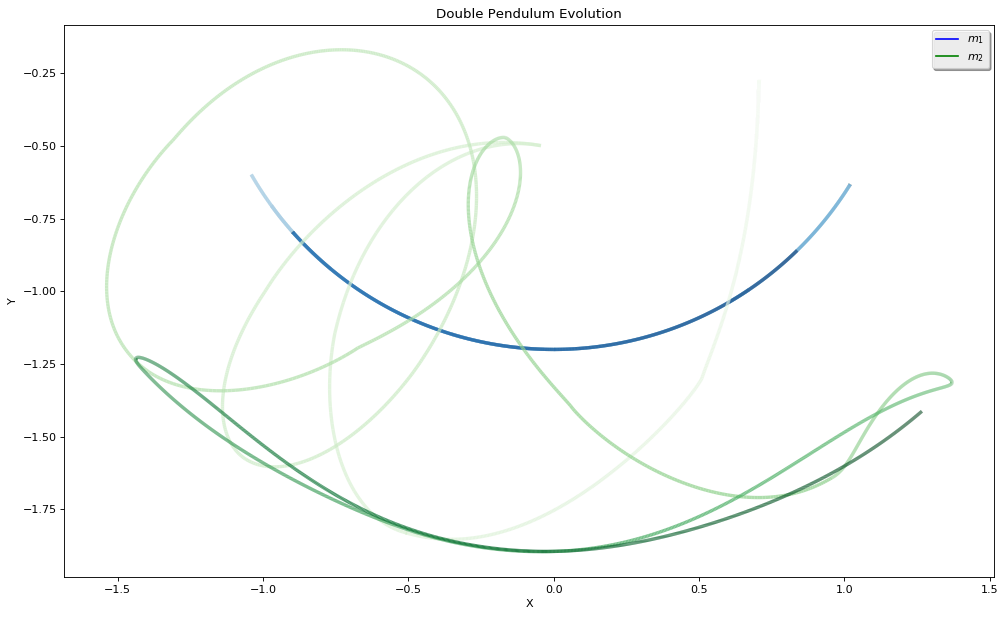

In [95]:
plot_paths(paths)